In [1]:
import torch 
from torch.nn import functional as F
import matplotlib.pyplot as plt 
from icecream import ic 
from sys import exit as e

plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
words = open("./data/names.txt", 'r').read().splitlines()
print(len(words))

32033


In [3]:
unique_chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(unique_chars)}
stoi['.'] = 0

itos = {i:c for c,i in stoi.items()}

itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
block_size = 3

def build_dataset(words):
  X, y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      X.append(context)
      y.append(stoi[ch])

      context = context[1:] + [stoi[ch]]

  X = torch.tensor(X)
  y = torch.tensor(y)
  return X, y

import random 
random.seed(42)
random.shuffle(words)
t1 = int(0.8 * len(words))
t2 = int(0.9 * len(words))

Xtr, ytr = build_dataset(words[:t1])
Xva, yva = build_dataset(words[t1:t2])
Xte, yte = build_dataset(words[t2:])

Xtr.shape, Xva.shape, Xte.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embed = 10 
n_hidden = 64
vocab_size = len(unique_chars)+1

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)

#Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/(n_embed * block_size)**0.5
b1 = torch.randn((n_hidden), generator=g) * 0.1
#Layer 2  
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size), generator=g) * 0.1
#BatchNorm 
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad=True

print(sum(p.nelement() for p in parameters))

4137


In [7]:
batch_size = 32 
n = 32 
idx = torch.randint(0, Xtr.shape[0], (n, ), generator=g)
Xb, yb = Xtr[idx], ytr[idx]

In [8]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ W1 + b1
#BatchNorm
bnmeani = (1/n) * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)  * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar+1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Non-linearity
h = torch.tanh(hpreact)
# Layer 2
logits = h @ W2 + b2 
# Loss 
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.5571, grad_fn=<NegBackward0>)

$\frac{\delta p}{\delta csi} = \frac{\delta p1}{csi} + \frac{\delta p2}{csi} + \frac{\delta p3}{csi}$

Because

$p = [counts[:0] \times csi , counts[:, 1] \times csi, counts[:,2] \times csi]$

Thats why, the gradients are added over the column.

In [9]:
# embcat = emb.view(emb.shape[0], -1)
#emb = C[Xb]
print(emb.shape, embcat.shape, C.shape, Xb.shape)


torch.Size([32, 3, 10]) torch.Size([32, 30]) torch.Size([27, 10]) torch.Size([32, 3])


In [10]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)

# grads have same shape as original tensor. Consider gradients of only indexed tensor. Others are 0
dlogprobs = torch.zeros_like(logprobs) # dL/dlogprobs 
dlogprobs[range(n), yb] = -1.0/n

dprobs = 1.0/probs * dlogprobs # dL/dprobs = dL/dlogprobs * dlogprobs/dprobs

# We sum across columns because internally, PyTorch has broadcasted the single col of counts_sum_inv
# for multiplication (counts * counts_sum_inv)
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # dL/dcounts_sum_inv = dL/dlogprobs * dlogprobs/dprobs * dprobs/dcounts_sum_inv
dcounts = counts_sum_inv * dprobs

dcounts_sum = -1 * counts_sum**-2 * dcounts_sum_inv

# Note: https://www.perplexity.ai/search/plt-draw-bar-graph-from-a-list-yH4Zu62pT3qj_qj9cC3qyQ#7
# Second dcounts branch. So add and accumulate the gradients
dcounts += torch.ones_like(counts) * dcounts_sum

# SImple
dnorm_logits = norm_logits.exp() * dcounts

dlogits = dnorm_logits.clone()
dlogit_maxes = (torch.ones_like(logits) * -1. * dnorm_logits).sum(1, keepdim=True)

dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits@ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = (1. - h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2*bndiff * dbndiff2

dhprebn = 1. * dbndiff
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0, keepdim=True) 

dhprebn += torch.ones_like(hprebn) * (1/n) * dbnmeani

dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)

# INDEXING
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[i, j]
    dC[ix] += demb[i, j]
# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [11]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.5571467876434326 diff: -2.384185791015625e-07


In [12]:
# Backward Pass 
dlogits = F.softmax(logits, dim=-1)
dlogits[range(n), yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


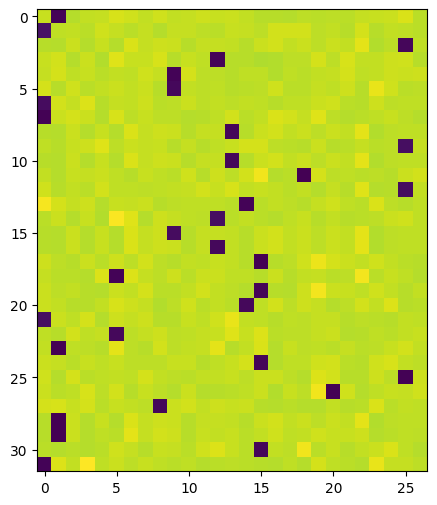

In [14]:
plt.imshow(dlogits.detach())
plt.show()

In [15]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

In [35]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use  this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :) 
    # dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    # grads have same shape as original tensor. Consider gradients of only indexed tensor. Others are 0
    dlogits = F.softmax(logits, dim=-1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    dh = dlogits@ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    dhpreact = (1. - h**2) * dh

    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

    dembcat = dhprebn @ W1.T 
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    demb = dembcat.view(emb.shape)
    # INDEXING
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # -----------------
    # -----------------
  # YOUR CODE HERE :)


    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/ 200000: 3.8354
  10000/ 200000: 2.1844
  20000/ 200000: 2.4262
  30000/ 200000: 2.4899
  40000/ 200000: 2.0123
  50000/ 200000: 2.3421
  60000/ 200000: 2.4065
  70000/ 200000: 2.1004
  80000/ 200000: 2.3460
  90000/ 200000: 2.1176
 100000/ 200000: 1.9322
 110000/ 200000: 2.3346
 120000/ 200000: 2.0428
 130000/ 200000: 2.4166
 140000/ 200000: 2.2850
 150000/ 200000: 2.1924
 160000/ 200000: 1.9430
 170000/ 200000: 1.8824
 180000/ 200000: 2.0226
 190000/ 200000: 1.8984


In [34]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [36]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, ytr),
    'val': (Xva, yva),
    'test': (Xte, yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.101194143295288
val 2.1394879817962646


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))